# Energy Forecast with PJM Hourly Energy Consumption data

#### About dataset:

PJM Hourly Energy Consumption Data

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

<center><img src="https://i.postimg.cc/dQm3zGyF/download.png" width="800"/></center>


Ideas of what you could do with this dataset:

Split the last year into a test set- can you build a model to predict energy consumption?

Find trends in energy consumption around hours of the day, holidays, or long term trends?

Understand how daily trends change depending of the time of year. Summer trends are very different than winter trends.


## Imports

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

## Load the dataset:

**We locate the file with all the data for all the different regions:**

In [2]:
df = pd.read_csv('data/pjm_hourly_est.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AEP       121273 non-null  float64
 1   COMED     66497 non-null   float64
 2   DAYTON    121275 non-null  float64
 3   DEOK      57739 non-null   float64
 4   DOM       116189 non-null  float64
 5   DUQ       119068 non-null  float64
 6   EKPC      45334 non-null   float64
 7   FE        62874 non-null   float64
 8   NI        58450 non-null   float64
 9   PJME      145366 non-null  float64
 10  PJMW      143206 non-null  float64
 11  PJM_Load  32896 non-null   float64
dtypes: float64(12)
memory usage: 17.7 MB


**Let us plot the data in each column to get an idea of their timeframes:**

Text(0, 0.5, 'hourly consumption [MW]')

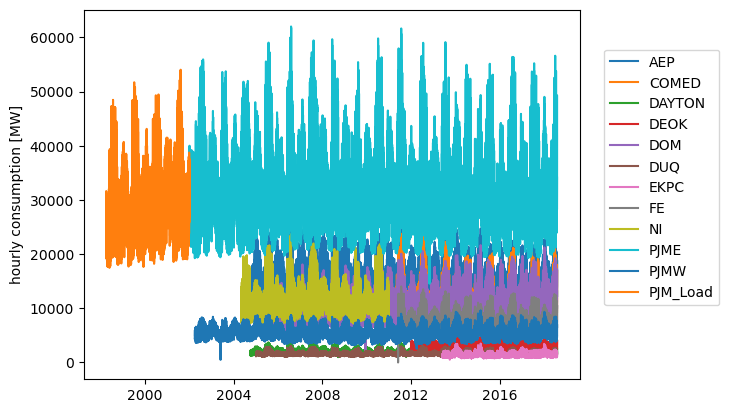

In [3]:
for col in df.columns:

    plt.plot(df[col], label=col)

plt.legend(loc=(1.05, 0.2))
plt.ylabel('hourly consumption [MW]')

**From now on we choose to work with the PJME data.**

In [4]:
df = pd.read_csv('data/PJME_hourly.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


**Let us zoom in and plot one year to see some seasonal trends:**

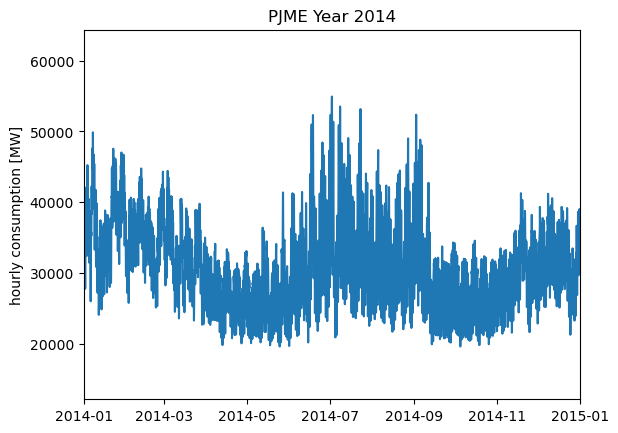

In [5]:
plt.plot(df['PJME_MW'])
plt.xlim(pd.Timestamp('2014-01'), pd.Timestamp('2015-01'))
plt.title('PJME Year 2014')
plt.ylabel('hourly consumption [MW]')
plt.show()

## Prepare the data

**We will divide the data into train/test sets and normalize the training values so that they fall between -1 and 1 (to improve training). Then we will train the model, and predict into a period that matches the test set. Finally, we'll forecast into an unknown future.**

### Create the train / validation split

**We choose the test size to be 90 days, and the training set to be 3 years**

In [6]:
y = df['PJME_MW'].values.astype(float)

# Define a test size
test_size = 24 * 7

# Define a training size
train_size = 24 * 365 * 3

# Create train and test sets
train_set = y[-train_size:-test_size]
test_set = y[-test_size:]

In [7]:
# Instantiate a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

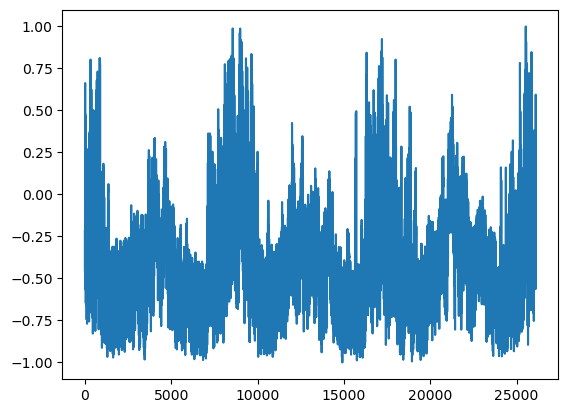

In [8]:
plt.plot(train_norm)

## Prepare data for LSTM

**We create our list of (seq, label) tuples from the training set**

**We choose the window to be a week (168 h), in order to capture seasonalities but not make it too large.**

In [9]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

# Define a window size
window_size = 24 * 7

# Define function to create (seq, label) tuples
def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

# Apply the input_data function to train_norm
train_data = input_data(train_norm, window_size)
len(train_data)

25944

**We arrange the data in batches to make training more efficient**

In [10]:
X = torch.stack([s for (s, l) in train_data])[:, :, None]  # [N, window, 1]
y = torch.stack([l for (s, l) in train_data])              # [N, 1]

train_ds = TensorDataset(X, y)

# Create the DataLoader with batch_size 64
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=True)

In [11]:
for seq, y_train in train_dl:
    break

seq.view(len(seq[0]), 1, -1).shape

torch.Size([168, 1, 64])

## Define the LSTM model

In [12]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):                      # x: [B, seq, 1]
        out, _ = self.lstm(x)                 
        last = out[:, -1, :]                   # [B, hidden]
        return self.linear(last)               # [B, 1]


In [13]:
model = LSTMnetwork()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

LSTMnetwork(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

## Train the model

In [461]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_dl:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()

        bs = len(seq)
        model.hidden = (torch.zeros(1, bs, model.hidden_size),
                        torch.zeros(1, bs, model.hidden_size))

        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {(time.time() - start_time)/60:.0f} minutes')

Epoch:  1 Loss: 0.00409057
Epoch:  2 Loss: 0.00148445
Epoch:  3 Loss: 0.00068850
Epoch:  4 Loss: 0.00062399
Epoch:  5 Loss: 0.00046134
Epoch:  6 Loss: 0.00038260
Epoch:  7 Loss: 0.00052033
Epoch:  8 Loss: 0.00034204
Epoch:  9 Loss: 0.00062252
Epoch: 10 Loss: 0.00040782
Epoch: 11 Loss: 0.00038152
Epoch: 12 Loss: 0.00030934
Epoch: 13 Loss: 0.00020737
Epoch: 14 Loss: 0.00041460
Epoch: 15 Loss: 0.00025475
Epoch: 16 Loss: 0.00023896
Epoch: 17 Loss: 0.00020870
Epoch: 18 Loss: 0.00035527
Epoch: 19 Loss: 0.00032310
Epoch: 20 Loss: 0.00026921
Epoch: 21 Loss: 0.00038375
Epoch: 22 Loss: 0.00026642
Epoch: 23 Loss: 0.00029865
Epoch: 24 Loss: 0.00021321
Epoch: 25 Loss: 0.00025557
Epoch: 26 Loss: 0.00018591
Epoch: 27 Loss: 0.00015488
Epoch: 28 Loss: 0.00013915
Epoch: 29 Loss: 0.00033705
Epoch: 30 Loss: 0.00022283
Epoch: 31 Loss: 0.00025899
Epoch: 32 Loss: 0.00022763
Epoch: 33 Loss: 0.00023628
Epoch: 34 Loss: 0.00014623
Epoch: 35 Loss: 0.00022497
Epoch: 36 Loss: 0.00024695
Epoch: 37 Loss: 0.00012772
E

### We save the trained model

In [506]:
torch.save(model.state_dict(), 'models/LSTM_hiddensize128.pt')

#### Loading the saved model:

In [16]:
# model = LSTMnetwork(input_size=1, hidden_size=128, output_size=1)
# model.load_state_dict(torch.load("models/LSTM_hiddensize128.pt"))
# model.eval()

LSTMnetwork(
  (lstm): LSTM(1, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

## Run predictions and compare to known test set

In [17]:
future = test_size

# seed: last real window
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    # seq needs shape [1, window, 1]
    seq = torch.FloatTensor(preds[-window_size:]).view(1, window_size, 1)

    with torch.no_grad():
        y_hat = model(seq)        # output shape [1, 1]
        preds.append(y_hat.item())

**Invert the normalization:**

In [18]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions

array([[32673.04887879],
       [30501.69885594],
       [29014.29428339],
       [28144.8981958 ],
       [28081.48382312],
       [29116.94744024],
       [30881.07742226],
       [33541.47478124],
       [35940.20143797],
       [38071.68248075],
       [40018.32899276],
       [41611.60133012],
       [42785.61857194],
       [43707.32784331],
       [44235.34567374],
       [44393.5270398 ],
       [44265.13030159],
       [43670.33612591],
       [42298.76264077],
       [40494.35216404],
       [39185.57423156],
       [37971.66313579],
       [35206.7688925 ],
       [32209.38443556],
       [29545.01616395],
       [27701.25363129],
       [26510.8626368 ],
       [25835.949983  ],
       [25799.70524693],
       [26626.83176547],
       [28148.3970964 ],
       [30554.59871507],
       [32745.68140176],
       [34573.42753048],
       [36153.33115646],
       [37352.28717962],
       [38207.46442624],
       [38893.48811413],
       [39351.84576157],
       [39600.40240518],


In [19]:
df[-test_size:]

,PJME_MW
Datetime,
2018-07-27 01:00:00,32798.0
2018-07-27 02:00:00,30772.0
2018-07-27 03:00:00,29279.0
2018-07-27 04:00:00,28422.0
2018-07-27 05:00:00,28437.0
...,...
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0


## Plot and discussion

In [20]:
x = np.arange('2018-07-27 01:00:00', '2018-08-03 01:00:00', dtype='datetime64[h]').astype('datetime64[h]')

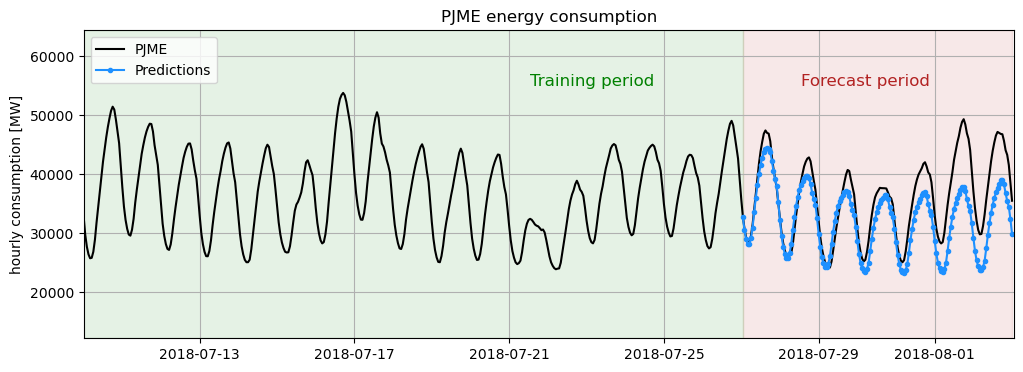

In [21]:
plt.figure(figsize=(12,4))

plt.autoscale(axis='x',tight=True)
plt.plot(df['PJME_MW'], '-k', linewidth=1.5, label='PJME')
plt.plot(x, true_predictions, '-o', color='dodgerblue', markersize=3, label='Predictions')

plt.axvspan(x[-168], x[-1], color='firebrick', alpha=0.1)
plt.axvspan('2017', x[-168], color='green', alpha=0.1)

plt.text(pd.Timestamp('2018-07-28 13:00:00'), 55000, "Forecast period", color='firebrick', fontsize=12)
plt.text(pd.Timestamp('2018-07-21 13:00:00'), 55000, "Training period", color='green', fontsize=12)

plt.ylabel('hourly consumption [MW]')
plt.title('PJME energy consumption')

plt.xlim(pd.Timestamp('2018-07-10'), pd.Timestamp('2018-08-03 01:00:00'))
plt.grid(True)
plt.legend(loc=2)
# plt.savefig("figures/forecast_plot.pdf", bbox_inches="tight")
plt.show()

Although the model slightly deviates toward the later part of the test period, this behavior is expected for autoregressive forecasts over extended horizons. The predictions are generated by iteratively feeding previous outputs back into the model, so small local errors naturally accumulate over time. In practical scenarios, these forecasts could be refined dynamically as new observations become available, reducing drift and improving accuracy closer to real time.

### Some metrics:

In [22]:
true_values = df['PJME_MW'][-test_size:].values

**Performance on 24h predictions:**

In [23]:
mae  = mean_absolute_error(true_values[:24], true_predictions[:24])
rmse = math.sqrt(mean_squared_error(true_values[:24], true_predictions[:24]))
r2   = r2_score(true_values[:24], true_predictions[:24])

print('24 h prediction performance:')
print(f"MAE:  {mae:.1f} MW")
print(f"RMSE: {rmse:.1f} MW")
print(f"R²:   {r2:.3f}")

24 h prediction performance:
MAE:  1097.8 MW
RMSE: 1526.1 MW
R²:   0.946


**Performance on 1 week predictions:**

In [24]:
mae  = mean_absolute_error(true_values[:168], true_predictions[:168])
rmse = math.sqrt(mean_squared_error(true_values[:168], true_predictions[:168]))
r2   = r2_score(true_values[:168], true_predictions[:168])

print('1 week prediction performance:')

print(f"MAE:  {mae:.1f} MW")
print(f"RMSE: {rmse:.1f} MW")
print(f"R²:   {r2:.3f}")

1 week prediction performance:
MAE:  3903.1 MW
RMSE: 4937.7 MW
R²:   0.460
